In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
import umap
# Machine Learning & Data Processing
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import rbf_kernel
# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from joblib import Parallel, delayed
# Dimensionality Reduction
from sklearn.manifold import TSNE
from sklearn.metrics import average_precision_score
# Hyperparameter Optimization
import optuna
from scipy.special import softmax
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import hdbscan 
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.stats import mode
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from joblib import Parallel, delayed
import scipy.stats as stats
import json
import joblib
import json
import shap
import pickle
from bio_embeddings.embed import ProtTransBertBFDEmbedder
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# CUDA & Torch Info
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU detected'}")

2025-02-25 16:39:58.860018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 16:39:58.860488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 16:39:58.923057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 16:40:02.778797: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-25 16:40:23.690282: W tensorflow/compiler/

PyTorch Version: 1.9.1+cu102
CUDA Version: 10.2
CUDA Available: True
GPU Name: NVIDIA A100-SXM4-40GB


In [3]:
embedder = ProtTransBertBFDEmbedder()
device = torch.device("cuda:0")  # Use GPU 0
#mbedder = embedder.to(device)

In [4]:
data = '../alphafold/AF2_disorder_all_features.csv'

data_df = pd.read_csv(data)
data_df['seq_mut'] = data_df['mut_seq']
data_df = data_df.loc[:, ~data_df.columns.str.startswith(('ref', 'mut'))]
#data_df.Class.value_counts()
data_df.columns.tolist()

['ESM1b_rankscore',
 'EVE_rankscore',
 'Class',
 'WT',
 'abs_delta_asphericity',
 'abs_delta_radius_of_gyration',
 'abs_delta_end_to_end_distance',
 'abs_delta_scaling_exponent',
 'abs_delta_prefactor',
 'integrated_fitCons_rankscore',
 'GM12878_fitCons_rankscore',
 'H1-hESC_fitCons_rankscore',
 'HUVEC_fitCons_rankscore',
 'LINSIGHT_rankscore',
 'GERP++_RS_rankscore',
 'GERP_91_mammals_rankscore',
 'phyloP100way_vertebrate_rankscore',
 'phyloP470way_mammalian_rankscore',
 'phyloP17way_primate_rankscore',
 'phastCons100way_vertebrate_rankscore',
 'phastCons470way_mammalian_rankscore',
 'phastCons17way_primate_rankscore',
 'SiPhy_29way_logOdds_rankscore',
 'bStatistic_converted_rankscore',
 'label',
 'size',
 'abs_delta_hpi_1.5_frac',
 'abs_delta_hpi_1.5',
 'abs_delta_hpi_2.0_frac',
 'abs_delta_hpi_2.0',
 'abs_delta_hpi_2.5_frac',
 'abs_delta_hpi_2.5',
 'abs_delta_length',
 'abs_delta_fraction_A',
 'abs_delta_fraction_C',
 'abs_delta_fraction_D',
 'abs_delta_fraction_E',
 'abs_delta_frac

In [5]:
def get_emb(a):
    per_residue_embedding = embedder.embed(a)
    per_residue_embedding = embedder.reduce_per_protein(per_residue_embedding)
    #print(per_residue_embedding)
    return per_residue_embedding


In [6]:

#data_df['wt_emb'] = data_df['WT'].apply(lambda x:get_emb(x))

#data_df['mut_emb'] = data_df['seq_mut'].apply(lambda x:get_emb(x))
#data_df.to_json('AF2_data_with_emb.json', orient='records', lines=True)
#delta_emb_df = data_df.copy()

# Compute L1 distance: Absolute difference
#delta_emb_df['delta_emb_L1'] = delta_emb_df.apply(lambda row: np.abs(row['wt_emb'] - row['mut_emb']), axis=1)

# Compute L2 distance: Squared difference
#delta_emb_df['delta_emb_L2'] = delta_emb_df.apply(lambda row: np.square(row['wt_emb'] - row['mut_emb']), axis=1)

# Compute average of embeddings
#delta_emb_df['delta_emb_average'] = delta_emb_df.apply(lambda row: (row['wt_emb'] + row['mut_emb']) / 2, axis=1)

# Compute Hadamard product: Element-wise multiplication
#delta_emb_df['delta_emb_hadamard'] = delta_emb_df.apply(lambda row: row['wt_emb'] * row['mut_emb'], axis=1)
#delta_emb_df.to_json('AF2_data_with_emb_l1_l2_average.json', orient='records', lines=True)

In [7]:
delta_emb_df = pd.read_json('AF2_data_with_emb_l1_l2_average.json', lines=True)

features_all = ['abs_delta_asphericity', 'abs_delta_radius_of_gyration',
       'abs_delta_end_to_end_distance', 'abs_delta_scaling_exponent',
       'abs_delta_prefactor', 'GERP++_RS_rankscore',
       'GERP_91_mammals_rankscore', 'phyloP100way_vertebrate_rankscore',
       'phyloP470way_mammalian_rankscore', 'phyloP17way_primate_rankscore',
       'phastCons100way_vertebrate_rankscore',
       'phastCons470way_mammalian_rankscore',
       'phastCons17way_primate_rankscore', 'SiPhy_29way_logOdds_rankscore','abs_delta_hpi_1.5_frac',
       'abs_delta_hpi_1.5', 'abs_delta_hpi_2.0_frac', 'abs_delta_hpi_2.0',
       'abs_delta_hpi_2.5_frac', 'abs_delta_hpi_2.5', 'abs_delta_length',
       'abs_delta_fraction_A', 'abs_delta_fraction_C', 'abs_delta_fraction_D',
       'abs_delta_fraction_E', 'abs_delta_fraction_F', 'abs_delta_fraction_G',
       'abs_delta_fraction_H', 'abs_delta_fraction_I', 'abs_delta_fraction_K',
       'abs_delta_fraction_L', 'abs_delta_fraction_M', 'abs_delta_fraction_N',
       'abs_delta_fraction_P', 'abs_delta_fraction_Q', 'abs_delta_fraction_R',
       'abs_delta_fraction_S', 'abs_delta_fraction_T', 'abs_delta_fraction_V',
       'abs_delta_fraction_W', 'abs_delta_fraction_Y', 'abs_delta_IEP',
       'abs_delta_molecular_weight', 'abs_delta_gravy', 'abs_delta_Asx',
       'abs_delta_Glx', 'abs_delta_Xle', 'abs_delta_Pos_charge',
       'abs_delta_Neg_charge', 'abs_delta_Aromatic', 'abs_delta_Alipatic',
       'abs_delta_lcs_score', 'abs_delta_lcs_fraction']


features_nocon = ['abs_delta_asphericity', 'abs_delta_radius_of_gyration',
       'abs_delta_end_to_end_distance', 'abs_delta_scaling_exponent',
       'abs_delta_prefactor','abs_delta_hpi_1.5_frac',
       'abs_delta_hpi_1.5', 'abs_delta_hpi_2.0_frac', 'abs_delta_hpi_2.0',
       'abs_delta_hpi_2.5_frac', 'abs_delta_hpi_2.5', 'abs_delta_length',
       'abs_delta_fraction_A', 'abs_delta_fraction_C', 'abs_delta_fraction_D',
       'abs_delta_fraction_E', 'abs_delta_fraction_F', 'abs_delta_fraction_G',
       'abs_delta_fraction_H', 'abs_delta_fraction_I', 'abs_delta_fraction_K',
       'abs_delta_fraction_L', 'abs_delta_fraction_M', 'abs_delta_fraction_N',
       'abs_delta_fraction_P', 'abs_delta_fraction_Q', 'abs_delta_fraction_R',
       'abs_delta_fraction_S', 'abs_delta_fraction_T', 'abs_delta_fraction_V',
       'abs_delta_fraction_W', 'abs_delta_fraction_Y', 'abs_delta_IEP',
       'abs_delta_molecular_weight', 'abs_delta_gravy', 'abs_delta_Asx',
       'abs_delta_Glx', 'abs_delta_Xle', 'abs_delta_Pos_charge',
       'abs_delta_Neg_charge', 'abs_delta_Aromatic', 'abs_delta_Alipatic',
       'abs_delta_lcs_score', 'abs_delta_lcs_fraction']

L1_features = features_nocon + ['delta_emb_L1']
L2_features = features_nocon + ['delta_emb_L2']
average_features = features_nocon + ['delta_emb_average']
hadamard_features = features_nocon + ['delta_emb_hadamard']

L1_features_eve = features_nocon + ['delta_emb_L1', 'EVE_rankscore']
L2_features_eve = features_nocon + ['delta_emb_L2', 'EVE_rankscore']
average_features_eve = features_nocon + ['delta_emb_average', 'EVE_rankscore']
hadamard_features_eve = features_nocon + ['delta_emb_hadamard', 'EVE_rankscore']

L1_features_esm1 = features_nocon + ['delta_emb_L1', 'ESM1b_rankscore']
L2_features_esm1 = features_nocon + ['delta_emb_L2', 'ESM1b_rankscore']
average_features_esm1 = features_nocon + ['delta_emb_average', 'ESM1b_rankscore']
hadamard_features_esm = features_nocon + ['delta_emb_hadamard', 'ESM1b_rankscore']


#L1_features = features_nocon 
##L2_features = features_nocon 
#average_features = features_nocon 
#hadamard_features = features_nocon 

#L1_features = ['delta_emb_L1']
#L2_features = ['delta_emb_L2']
#average_features = ['delta_emb_average']
#hadamard_features = ['delta_emb_hadamard']

delta_emb_L1_df = delta_emb_df[L1_features]
delta_emb_L2_df = delta_emb_df[L2_features]
delta_emb_average_df = delta_emb_df[average_features]
delta_emb_hadamard_df = delta_emb_df[hadamard_features]

delta_eve_emb_L1_df = delta_emb_df[L1_features_eve]
delta_eve_emb_L2_df = delta_emb_df[L2_features_eve]
delta_eve_emb_average_df = delta_emb_df[average_features_eve]
delta_eve_emb_hadamard_df = delta_emb_df[hadamard_features_eve]


delta_emb_L1_esm_df = delta_emb_df[L1_features_esm1]
delta_emb_L2_esm_df = delta_emb_df[L2_features_esm1]
delta_emb_average_esm_df = delta_emb_df[average_features_esm1]
delta_emb_hadamard_esm_df = delta_emb_df[hadamard_features_esm]


def expand_array_column(df, array_column_name, class_column_name=None):
    if array_column_name not in df.columns:
        raise ValueError(f"Column '{array_column_name}' not found in the DataFrame.")
    
    # Expand the array column into separate columns
    array_columns = df[array_column_name].apply(pd.Series)
    array_columns.columns = [f'{array_column_name}_value_{i+1}' for i in range(array_columns.shape[1])]
    
    # Drop the original array column and concatenate the expanded columns
    expanded_df = pd.concat([df.drop(columns=[array_column_name]), array_columns], axis=1)
    
    # Retain the class column if specified
    if class_column_name and class_column_name in df.columns:
        expanded_df[class_column_name] = df[class_column_name]
    
    return expanded_df

#array_columns = delta_emb_L1_df['delta_emb_L1'].apply(pd.Series)
#array_columns.columns = [f'array_value_{i+1}' for i in range(array_columns.shape[1])]
#delta_emb_L1_df = pd.concat([delta_emb_L1_df.drop(columns=['delta_emb_L1']), array_columns], axis=1)
#delta_emb_L1_df['Class'] = delta_emb_df['Class']

delta_emb_L1_df = expand_array_column(delta_emb_L1_df, 'delta_emb_L1')
delta_emb_L2_df = expand_array_column(delta_emb_L2_df, 'delta_emb_L2')
delta_emb_average_df = expand_array_column(delta_emb_average_df, 'delta_emb_average')
delta_emb_hadamard_df = expand_array_column(delta_emb_hadamard_df, 'delta_emb_hadamard')


delta_eve_emb_L1_df = expand_array_column(delta_eve_emb_L1_df, 'delta_emb_L1')
delta_eve_emb_L2_df = expand_array_column(delta_eve_emb_L2_df, 'delta_emb_L2')
delta_eve_emb_average_df = expand_array_column(delta_eve_emb_average_df, 'delta_emb_average')
delta_eve_emb_hadamard_df = expand_array_column(delta_eve_emb_hadamard_df, 'delta_emb_hadamard')


delta_esm_emb_L1_df = expand_array_column(delta_emb_L1_esm_df, 'delta_emb_L1')
delta_esm_emb_L2_df = expand_array_column(delta_emb_L2_esm_df, 'delta_emb_L2')
delta_esm_emb_average_df = expand_array_column(delta_emb_average_esm_df, 'delta_emb_average')
delta_esm_emb_hadamard_df = expand_array_column(delta_emb_hadamard_esm_df, 'delta_emb_hadamard')

In [22]:


def create_train_test(data, feature_cols, target_col, test_size=0.3, random_state=42 ):
    X = data[feature_cols]
    y = data[target_col]
    
    # Encode the target if necessary
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

def train_xgboost_with_cv(X, y, method, model_name, n_splits=10, random_state=42):
    #kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics_list = []
    models = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        #print(f"Fold {fold}: Class Distribution in Test Set:\n{y_test.value_counts(normalize=True)}\n")

        # Initialize and train the XGBoost classifier
        model = XGBClassifier(
            use_label_encoder=False, 
            eval_metric='logloss', 
            random_state=random_state,
            tree_method="gpu_hist",  # Use GPU for faster training
            n_jobs=-1  # Use all CPU cores for multi-threading
        )
        model.fit(X_train, y_train)
        models.append(model)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)
        # Compute balanced AUC (weighted by class proportions)
        #sample_weights = compute_sample_weight("balanced", y_test)
        #balanced_roc_auc = roc_auc_score(y_test, y_pred_proba, sample_weight=sample_weights)

        # Store metrics
        metrics_list.append({
            'fold': fold,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'auc_pr': auc_pr, 'method': method, 'model_name': model_name
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(metrics_list)
    
    return results_df, models


def run_cv(model, X, y, method, model_name,n_splits=10, random_state=42):
    """
    Generic function to train and evaluate a model using cross-validation.
    Uses parallelization for speed-up.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Convert to NumPy arrays for faster indexing
    X = np.array(X)
    y = np.array(y)

    def train_fold(fold, train_idx, test_idx):
        """Train and evaluate a single fold"""
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)
        return {'fold': fold, 'accuracy': accuracy, 'roc_auc': roc_auc, 'auc_pr': auc_pr, 'method': method, 'model_name': model_name}, model

    # Run cross-validation in parallel
    results = Parallel(n_jobs=-1)(
        delayed(train_fold)(fold, train_idx, test_idx) for fold, (train_idx, test_idx) in enumerate(skf.split(X, y))
    )

    # Extract results and trained models
    metrics_list, models = zip(*results)
    
    return pd.DataFrame(metrics_list), list(models)

# Random Forest (Optimized)
def train_random_forest_with_cv(X, y,method, model_name, n_splits=10, random_state=42):
    model = RandomForestClassifier(n_jobs=-1, random_state=random_state)
    return run_cv(model, X, y, method, model_name, n_splits, random_state)

# Naive Bayes (Optimized)
def train_naive_bayes_with_cv(X, y,method, model_name, n_splits=10, random_state=42):
    model = GaussianNB()
    return run_cv(model, X, y, method, model_name, n_splits, random_state)

def train_mlp_with_cv(X, y, method, model_name, n_splits=10, random_state=42):
    model = MLPClassifier(
        hidden_layer_sizes=(100,), 
        learning_rate_init=0.001,
        max_iter=1000, 
        batch_size="auto", 
        random_state=random_state
    )
    return run_cv(model, X, y, method, model_name, n_splits, random_state)

def train_optimize_xgboost(X, y, eva_type, n_splits=10, n_trials=150, random_state=42, save_path="xgboost_results"):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    # Split into training-validation and test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    trial_results = []  # Store all trial scores

    def objective(trial):
        """Objective function for Optuna hyperparameter tuning, recording fold scores."""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'tree_method': "gpu_hist" 
        }

        # Cross-validation setup
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        fold_scores = []
        accuracy_scores =[]
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_val, y_train_val)):
            X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
            y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

            model = XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=random_state,
                **params
            )
            model.fit(X_train, y_train)

            y_pred_proba = model.predict_proba(X_val)[:, 1]
            y_pred = model.predict(X_val)
            roc_auc = roc_auc_score(y_val, y_pred_proba)
            accuracy = accuracy_score(y_val, y_pred)
            fold_scores.append(roc_auc)
            accuracy_scores.append(accuracy)
        mean_score = np.mean(fold_scores)  # Mean ROC-AUC across folds

        # Store trial results
        trial_results.append({
            'trial_number': trial.number,
            'params': params,
            'fold_scores': fold_scores,
            'accuracy_scores': accuracy_scores, 
            'mean_score': mean_score
        })

        return mean_score

    # Run Optuna optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Convert trial results to DataFrame
    trials_df = pd.DataFrame(trial_results)

    # Save Optuna trial results (including fold scores)
    trials_df.to_csv(f"{save_path}/{eva_type}_optuna_trials_detailed.csv", index=False)
    trials_df.to_json(f"{save_path}/{eva_type}_optuna_trials_detailed.json", orient="records", indent=4)

    # Extract best parameters
    best_params = study.best_params
    best_params['tree_method'] = "gpu_hist"  # Ensure GPU acceleration for best model
    print("\nBest hyperparameters found:\n", best_params)

    # Save best hyperparameters as JSON
    with open(f"{save_path}/{eva_type}_best_hyperparameters.json", "w") as json_file:
        json.dump(best_params, json_file, indent=4)

    # Train the best model on the full training-validation set
    best_model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state,
        **best_params
    )
    best_model.fit(X_train_val, y_train_val)

    # Save the trained model
    joblib.dump(best_model, f"{save_path}/{eva_type}_best_xgboost_model.pkl")

    # Test performance on the hold-out set
    y_test_pred = best_model.predict(X_test)
    y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

    test_results = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_pred_proba)
    }

    print("\nTest Set Performance:\n", test_results)

    # Save test results
    with open(f"{save_path}/{eva_type}_test_results.json", "w") as json_file:
        json.dump(test_results, json_file, indent=4)

    return best_params, trials_df, test_results

def create_binary_dnn(input_dim, hidden_units=[256, 128, 64], dropout_rate=0.3):
    """
    Creates a 3-layer deep neural network model for binary classification.
    """
    with tf.device('/GPU:0'):  # Force GPU usage
        model = Sequential([
            Dense(hidden_units[0], activation='relu', input_shape=(input_dim,)),
            BatchNormalization(),
            Dropout(dropout_rate),

            Dense(hidden_units[1], activation='relu'),
            BatchNormalization(),
            Dropout(dropout_rate),

            Dense(hidden_units[2], activation='relu'),
            BatchNormalization(),
            Dropout(dropout_rate),

            Dense(1, activation='sigmoid')  # Single output neuron for binary classification
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    return model

def create_binary_dnn(input_dim, hidden_units=[256, 128, 64], dropout_rate=0.3):
    model = Sequential([
        Dense(hidden_units[0], activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(hidden_units[1], activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(hidden_units[2], activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid')  
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


def train_binary_dnn_with_cv(X, y, method, model_name, n_splits=5, random_state=42, epochs=50, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    X = np.array(X)
    y = np.array(y)

    input_dim = X.shape[1]
    fold_results = []
    trained_models = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Training Fold {fold + 1}/{n_splits} on GPU...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = create_binary_dnn(input_dim)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        with tf.device('/GPU:0'):
            model.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test), 
                      callbacks=[early_stopping], 
                      verbose=1)

        y_pred_proba = model.predict(X_test)[:, 0]
        y_pred = (y_pred_proba > 0.5).astype(int)

        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)

        fold_results.append({'fold': fold, 'accuracy': accuracy, 'roc_auc': roc_auc, 'auc_pr': auc_pr, 'method': method, 'model_name': model_name})
        trained_models.append(model)

    return pd.DataFrame(fold_results), trained_models

In [9]:

# Extract features and labels
#features = delta_emb_L1_df.drop(columns=['Class'])
labels = delta_emb_df['Class']
y = labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

# Standardize the features
scaler = StandardScaler()


In [10]:
columns_emb_L1 = [ i for i in delta_emb_L1_df.columns if i.startswith("delta_emb_L1")]
columns_emb_L2 = [ i for i in delta_emb_L2_df.columns if i.startswith("delta_emb_L2")]
columns_emb_average = [ i for i in delta_emb_average_df.columns if i.startswith("delta_emb_average")]
columns_emb_hadamard = [ i for i in delta_emb_hadamard_df.columns if i.startswith("delta_emb_hadamard")]
delta_emb_L1_only_df = delta_emb_L1_df[columns_emb_L1]
L1_features = delta_emb_L1_only_df.columns
#delta_emb_L1_only_df['Class'] = delta_emb_df['Class']
delta_emb_L2_only_df = delta_emb_L2_df[columns_emb_L2]
L2_features = delta_emb_L2_only_df.columns
#delta_emb_L2_only_df['Class'] =  delta_emb_df['Class']
delta_emb_average_only_df = delta_emb_average_df[columns_emb_average]
average_features = delta_emb_average_only_df.columns
#delta_emb_average_only_df['Class'] = delta_emb_df['Class']
delta_emb_hadamard_only_df = delta_emb_hadamard_df[columns_emb_hadamard]
hadamard_features = delta_emb_hadamard_only_df.columns
#delta_emb_hadamard_only_df['Class'] = delta_emb_df['Class']



L1_xgb_results, L1_xgb_model = train_xgboost_with_cv(delta_emb_L1_only_df, y_encoded, 'L1', "XGB")
L1_rf_results, L1_rf_models = train_random_forest_with_cv(delta_emb_L1_only_df, y_encoded, 'L1', "RF")
L1_nb_results, L1_nb_models = train_naive_bayes_with_cv(delta_emb_L1_only_df, y_encoded, 'L1', "NB")
L1_mlp_results, L1_mlp_models = train_mlp_with_cv(delta_emb_L1_only_df, y_encoded, 'L1', "MLP")

L2_xgb_results, L2_xgb_model = train_xgboost_with_cv(delta_emb_L2_only_df, y_encoded, 'L2', "XGB")
L2_rf_results, L2_rf_models = train_random_forest_with_cv(delta_emb_L2_only_df, y_encoded, 'L2', "RF")
L2_nb_results, L2_nb_models = train_naive_bayes_with_cv(delta_emb_L2_only_df, y_encoded, 'L2', "NB")
L2_mlp_results, L2_mlp_models = train_mlp_with_cv(delta_emb_L2_only_df, y_encoded, 'L2', "MLP")

average_xgb_results, average_xgb_model = train_xgboost_with_cv(delta_emb_average_only_df, y_encoded, 'Average', "XGB")
average_rf_results, average_rf_models = train_random_forest_with_cv(delta_emb_average_only_df, y_encoded, "Average", "RF")
average_nb_results, average_nb_models = train_naive_bayes_with_cv(delta_emb_average_only_df, y_encoded, 'Average', "NB")
average_mlp_results, average_mlp_models = train_mlp_with_cv(delta_emb_average_only_df, y_encoded, 'Average', "MLP")

hadamard_xgb_results, hadamard_xgb_model = train_xgboost_with_cv(delta_emb_hadamard_only_df, y_encoded, 'Hadamard', "XGB")
hadamard_rf_results, hadamard_rf_models = train_random_forest_with_cv(delta_emb_hadamard_only_df, y_encoded, 'Hadamard', "RF")
hadamard_nb_results, hadamard_nb_models = train_naive_bayes_with_cv(delta_emb_hadamard_only_df, y_encoded, 'Hadamard', "NB")
hadamard_mlp_results, hadamard_mlp_models = train_mlp_with_cv(delta_emb_hadamard_only_df, y_encoded, 'hadamard', "MLP")

/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/projects/wangc/rohan/miniconda3/envs/soursop/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and 

In [11]:
#### Select the feature set for UMAP (Change to L2, Average, or Hadamard if needed)
#features = delta_emb_hadamard_only_df.values  # Convert DataFrame to NumPy array
#labels = y_encoded  # Class labels

# Perform UMAP dimensionality reduction
#umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
#embedding = umap_model.fit_transform(features)

#n_clusters = len(set(labels))  # Use the number of unique classes as an estimate for clusters
#kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#cluster_labels = kmeans.fit_predict(embedding)

# Create a scatter plot of the UMAP projection with clusters
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="tab10", alpha=0.7)

#plt.title("Unsupervised Clustering on UMAP Projection")
#plt.xlabel("UMAP Dimension 1")
#plt.ylabel("UMAP Dimension 2")
#plt.legend(title="Cluster")
#plt.show()

#true_labels = LabelEncoder().fit_transform(y_encoded)
#def map_clusters_to_labels(true_labels, cluster_labels):
#    """Maps K-Means cluster labels to actual labels using majority voting."""
#    label_mapping = {}
#    mapped_labels = np.zeros_like(cluster_labels)
    
#    for cluster in set(cluster_labels):
#        mask = (cluster_labels == cluster)
#        majority_label = mode(true_labels[mask])[0]  # Find the most common true label in the cluster
#        label_mapping[cluster] = majority_label
#        mapped_labels[mask] = majority_label
    
#    return mapped_labels

# Map predicted cluster labels to actual class labels
#predicted_labels = map_clusters_to_labels(labels, cluster_labels)

# Compute accuracy
#clustering_accuracy = accuracy_score(labels, predicted_labels)

# Compute AUC (only for binary classification)
#if len(np.unique(true_labels)) == 2:
#    clustering_auc = roc_auc_score(labels, predicted_labels)
#else:
#    clustering_auc = "Not applicable (multi-class AUC requires one-vs-all approach)"

# Display results
#clustering_results = {
#    "Clustering Accuracy": clustering_accuracy,
#    "Clustering AUC": clustering_auc
#}

#from sklearn.decomposition import PCA
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.metrics.pairwise import laplacian_kernel
#from scipy.spatial.distance import cdist
# Standardize features
#scaler = StandardScaler()
#features_scaled = scaler.fit_transform(delta_emb_hadamard_only_df.values)

# Apply softmax transformation along each feature dimension
#features_softmax = softmax(delta_emb_L1_only_df, axis=1)
#pca = PCA(n_components=50)  # Keep top 50 principal components
#features_pca = pca.fit_transform(features_softmax)
#features_kernel = polynomial_kernel(features_pca)
#features_cosine = cosine_similarity(features_softmax)
#features_kernel = rbf_kernel(features_softmax)

#def kl_divergence_matrix(X):
#    """Computes the pairwise KL divergence matrix."""
#    n = X.shape[0]
#    kl_matrix = np.zeros((n, n))
    
#    for i in range(n):
#        for j in range(n):
#            if i != j:  # Avoid division by zero
#                kl_matrix[i, j] = np.sum(X[i] * np.log((X[i] + 1e-10) / (X[j] + 1e-10)))  # Add epsilon to avoid log(0)

#    return kl_matrix

#features_kl = kl_divergence_matrix(features_softmax)
# Optimize UMAP parameters
#umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)
#embedding = umap_model.fit_transform(features_kl, degree=3)

# Apply HDBSCAN for clustering
#clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_method='eom')
#cluster_labels = clusterer.fit_predict(embedding)

# Scatter plot of the UMAP projection with HDBSCAN clusters
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="tab10", alpha=0.7)

#plt.title("HDBSCAN Clustering on UMAP Projection")
#plt.xlabel("UMAP Dimension 1")
#plt.ylabel("UMAP Dimension 2")
#plt.legend(title="Cluster")
#plt.show()

In [12]:
L1_standardized_features = scaler.fit_transform(delta_emb_L1_df)
L2_standardized_features = scaler.fit_transform(delta_emb_L2_df)
average_standardized_features = scaler.fit_transform(delta_emb_average_df)
hadamard_standardized_features = scaler.fit_transform(delta_emb_hadamard_df)

L1_standardized_features_df = pd.DataFrame(L1_standardized_features, columns=delta_emb_L1_df.columns)
L2_standardized_features_df = pd.DataFrame(L2_standardized_features, columns=delta_emb_L2_df.columns)
average_standardized_features_df = pd.DataFrame(average_standardized_features, columns=delta_emb_average_df.columns)
hadamard_standardized_features_df = pd.DataFrame(hadamard_standardized_features, columns=delta_emb_hadamard_df.columns)


L1_X = L1_standardized_features_df.apply(pd.to_numeric, errors='coerce')
L2_X = L1_standardized_features_df.apply(pd.to_numeric, errors='coerce')
average_X = average_standardized_features_df.apply(pd.to_numeric, errors='coerce')
hadamard_X = hadamard_standardized_features_df.apply(pd.to_numeric, errors='coerce')



In [13]:
fold_metrics_xg_l1_df, models_l1_xg = train_xgboost_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "XGboost",n_splits=10, random_state=42)
fold_metrics_xg_l2_df, models_l2_xg = train_xgboost_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "XGboost",n_splits=10, random_state=42)
fold_metrics_xg_average_df, models_average_xg = train_xgboost_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "XGboost",  n_splits=10, random_state=42)
fold_metrics_xg_hadamard_df, models_hadamard_xg = train_xgboost_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "XGboost", n_splits=10, random_state=42)

fold_metrics_rf_l1_df, models_l1_rf = train_random_forest_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "Random Forest",n_splits=10, random_state=42)
fold_metrics_rf_l2_df, models_l2_rf = train_random_forest_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "Random Forest",n_splits=10, random_state=42)
fold_metrics_rf_average_df, models_average_rf = train_random_forest_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "Random Forest",  n_splits=10, random_state=42)
fold_metrics_rf_hadamard_df, models_hadamard_rf = train_random_forest_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "Random Forest", n_splits=10, random_state=42)

fold_metrics_nb_l1_df, models_l1_nb = train_naive_bayes_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "Naive Bayes",n_splits=10, random_state=42)
fold_metrics_nb_l2_df, models_l2_nb = train_naive_bayes_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "Naive Bayes",n_splits=10, random_state=42)
fold_metrics_nb_average_df, models_average_nb = train_naive_bayes_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "Naive Bayes",  n_splits=10, random_state=42)
fold_metrics_nb_hadamard_df, models_hadamard_nb = train_naive_bayes_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "Naive Bayes", n_splits=10, random_state=42)

fold_metrics_mlp_l1_df, models_l1_mlp = train_mlp_with_cv(L1_X, y_encoded, 'L1 + PS + gIDRc', "MLP",n_splits=10, random_state=42)
fold_metrics_mlp_l2_df, models_l2_mlp = train_mlp_with_cv(L2_X, y_encoded, "L2 + PS + gIDRc", "MLP",n_splits=10, random_state=42)
fold_metrics_mlp_average_df, models_average_mlp = train_mlp_with_cv(average_X, y_encoded, "Average + PS + gIDRc", "MLP",  n_splits=10, random_state=42)
fold_metrics_mlp_hadamard_df, models_hadamard_mlp = train_mlp_with_cv(hadamard_X, y_encoded, "Hadamard + PS + gIDRc", "MLP", n_splits=10, random_state=42)

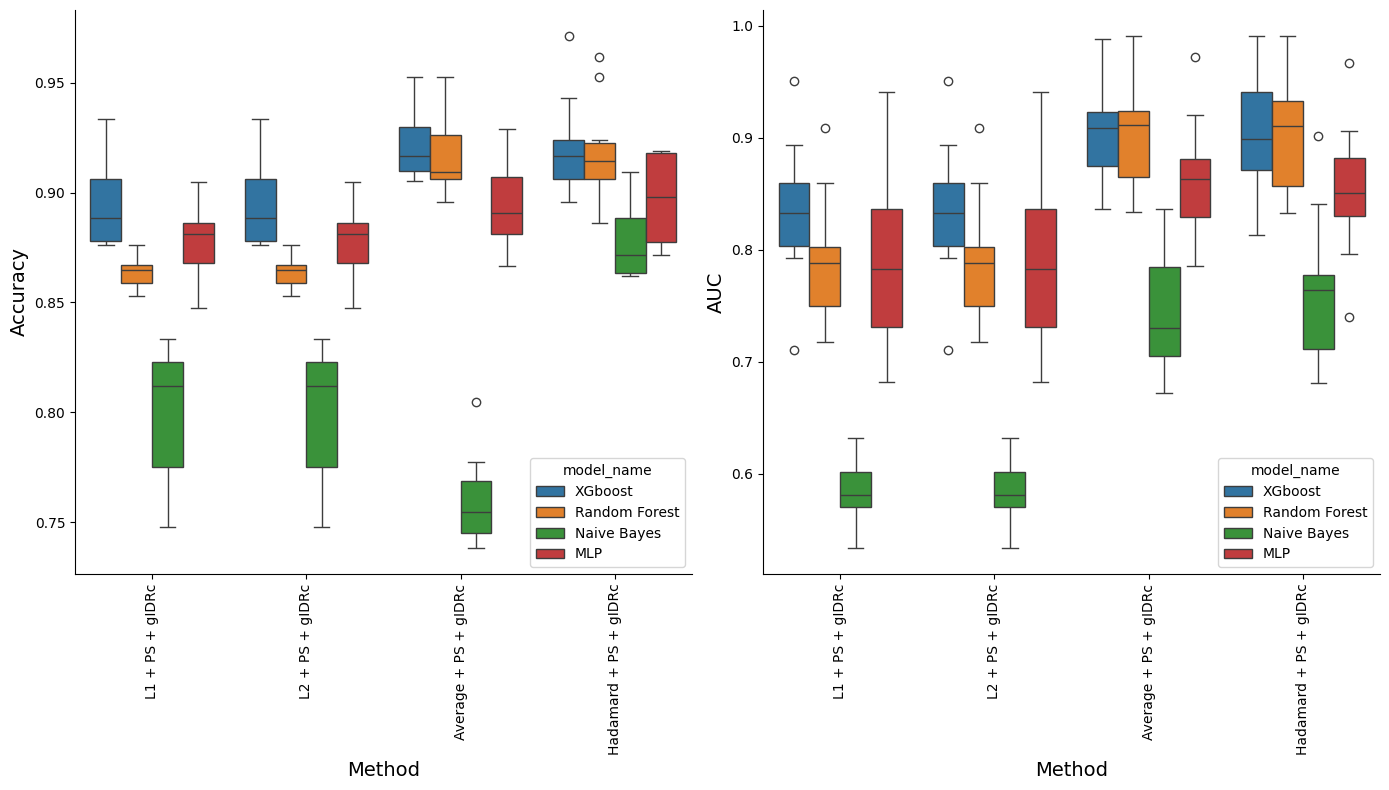

In [14]:
# List of all results DataFrames
results_model_list = [
    fold_metrics_xg_l1_df, fold_metrics_xg_l2_df, fold_metrics_xg_average_df, fold_metrics_xg_hadamard_df,
    fold_metrics_rf_l1_df, fold_metrics_rf_l2_df, fold_metrics_rf_average_df, fold_metrics_rf_hadamard_df,
    fold_metrics_nb_l1_df, fold_metrics_nb_l2_df, fold_metrics_nb_average_df, fold_metrics_nb_hadamard_df,
    fold_metrics_mlp_l1_df, fold_metrics_mlp_l2_df, fold_metrics_mlp_average_df, fold_metrics_mlp_hadamard_df
]

# Concatenate all results
emd_results_df = pd.concat(results_model_list, ignore_index=True)

# Set a blue-themed color palette
diverse_palette = sns.color_palette("tab10") 
plt.figure(figsize=(14, 8))


plt.subplot(1, 2, 1)
sns.boxplot(data=emd_results_df, x='method', y='accuracy', hue='model_name', palette=diverse_palette)
#plt.title('Accuracy by Method')
plt.xticks(rotation=90)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
#plt.grid(True)

# AUC box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=emd_results_df, x='method', y='roc_auc', hue='model_name', palette=diverse_palette)
#plt.title('AUC by Method')
plt.xticks(rotation=90)
plt.xlabel('Method', fontsize=14)
plt.ylabel('AUC', fontsize=14)
#plt.grid(True)
sns.despine()
plt.tight_layout()
plt.savefig('model_emb_results.png', dpi=300)
plt.show()



In [15]:
# Define models and methods for comparison
models = ['XGboost', 'Random Forest', 'Naive Bayes', 'MLP']
methods = ['L1 + PS + gIDRc', 'L2 + PS + gIDRc', 'Average + PS + gIDRc', 'Hadamard + PS + gIDRc']

# Store results
results_roc_auc = []
results_accuracy = []

# Loop through all model-method combinations
for model1 in models:
    for model2 in models:
        if model1 != model2:  # Avoid comparing the same model
            for method in methods:
                # Extract ROC AUC scores
                scores1_roc = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model1)]['roc_auc']
                scores2_roc = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model2)]['roc_auc']
                scores1_roc_mean = scores1_roc.mean()
                scores2_roc_mean = scores2_roc.mean()
                
                # Extract Accuracy scores
                scores1_acc = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model1)]['accuracy']
                scores2_acc = emd_results_df[(emd_results_df['method'] == method) & (emd_results_df['model_name'] == model2)]['accuracy']
                scores1_acc_mean =  scores1_acc.mean()
                scores2_acc_mean =  scores2_acc.mean()
                
                # Perform Mann-Whitney U test for ROC AUC
                if not scores1_roc.empty and not scores2_roc.empty:
                    stat_roc, p_roc = stats.mannwhitneyu(scores1_roc, scores2_roc, alternative='two-sided')
                    results_roc_auc.append([method, model1, model2, scores1_roc_mean,  scores2_roc_mean, stat_roc, p_roc])

                # Perform Mann-Whitney U test for Accuracy
                if not scores1_acc.empty and not scores2_acc.empty:
                    stat_acc, p_acc = stats.mannwhitneyu(scores1_acc, scores2_acc, alternative='two-sided')
                    results_accuracy.append([method, model1, model2, scores1_acc_mean, scores2_acc_mean, stat_acc, p_acc])

# Convert results to DataFrame for better visualization
pm_roc_auc_df = pd.DataFrame(results_roc_auc, columns=['Method', 'Model_1', 'Model_2', 'Model_1_mean_roc', 'Model_2_mean_roc', 'U_Statistic', 'P_Value'])
pm_accuracy_df = pd.DataFrame(results_accuracy, columns=['Method', 'Model_1', 'Model_2','Model_1_mean_accuracy', 'Model_2_mean_accuracy', 'U_Statistic', 'P_Value'])
pm_roc_auc_df.to_csv("../protien_embedding_combination_roc_results.csv", index=None)
pm_accuracy_df.to_csv("../protien_embedding_combination_accuracy_results.csv", index=None)
pm_combined_df = pd.merge(
    pm_roc_auc_df,
    pm_accuracy_df,
    on=['Method', 'Model_1', 'Model_2'],
    suffixes=('_roc', '_accuracy')
)

# Save the combined results
pm_combined_df.to_csv("../output/protien_embedding_combination_results.csv", index=False)

In [16]:
pm_combined_df

,Method,Model_1,Model_2,Model_1_mean_roc,Model_2_mean_roc,U_Statistic_roc,P_Value_roc,Model_1_mean_accuracy,Model_2_mean_accuracy,U_Statistic_accuracy,P_Value_accuracy
0,L1 + PS + gIDRc,XGboost,Random Forest,0.835420,0.790814,71.0,0.121225,0.893555,0.864076,99.0,0.000237
1,L2 + PS + gIDRc,XGboost,Random Forest,0.835420,0.790814,71.0,0.121225,0.893555,0.864076,99.0,0.000237
2,Average + PS + gIDRc,XGboost,Random Forest,0.908970,0.904320,54.0,0.791337,0.920641,0.918260,59.0,0.516555
3,Hadamard + PS + gIDRc,XGboost,Random Forest,0.904375,0.904018,53.0,0.850107,0.920634,0.919215,52.0,0.909279
4,L1 + PS + gIDRc,XGboost,Naive Bayes,0.835420,0.582106,100.0,0.000183,0.893555,0.799431,100.0,0.000180
5,L2 + PS + gIDRc,XGboost,Naive Bayes,0.835420,0.582106,100.0,0.000183,0.893555,0.799431,100.0,0.000180
6,Average + PS + gIDRc,XGboost,Naive Bayes,0.908970,0.743077,100.0,0.000183,0.920641,0.759503,100.0,0.000180
7,Hadamard + PS + gIDRc,XGboost,Naive Bayes,0.904375,0.763567,94.0,0.001008,0.920634,0.878323,93.5,0.001113
8,L1 + PS + gIDRc,XGboost,MLP,0.835420,0.790477,67.0,0.212294,0.893555,0.878334,69.0,0.161025
9,L2 + PS + gIDRc,XGboost,MLP,0.835420,0.790477,67.0,0.212294,0.893555,0.878334,69.0,0.161025


In [23]:
y_encoded
xg_best_params, xg_trial_df, xg_test_results = train_optimize_xgboost(hadamard_X, y_encoded, 'default')





[I 2025-02-25 17:37:46,352] A new study created in memory with name: no-name-6a2d0ec3-67c5-4b57-9011-1240fb8f148c
[I 2025-02-25 17:37:55,708] Trial 0 finished with value: 0.9055782678859602 and parameters: {'n_estimators': 92, 'max_depth': 5, 'learning_rate': 0.12375560953572842, 'colsample_bytree': 0.520180592208877, 'subsample': 0.5844113707196226, 'gamma': 0.2083986878800831, 'min_child_weight': 5, 'reg_alpha': 8.172486925161518, 'reg_lambda': 6.464279890913024}. Best is trial 0 with value: 0.9055782678859602.
[I 2025-02-25 17:38:05,372] Trial 1 finished with value: 0.9009994620763851 and parameters: {'n_estimators': 121, 'max_depth': 5, 'learning_rate': 0.22161714034691724, 'colsample_bytree': 0.8293761867340399, 'subsample': 0.8366713690606604, 'gamma': 0.8973411685463517, 'min_child_weight': 9, 'reg_alpha': 2.725234970655487, 'reg_lambda': 8.702731569293867}. Best is trial 0 with value: 0.9055782678859602.
[I 2025-02-25 17:38:15,323] Trial 2 finished with value: 0.902352339967724


Best hyperparameters found:
 {'n_estimators': 393, 'max_depth': 10, 'learning_rate': 0.01012230112871361, 'colsample_bytree': 0.5310141426120937, 'subsample': 0.9991590445202129, 'gamma': 2.0009879739989973, 'min_child_weight': 1, 'reg_alpha': 0.31373244822327007, 'reg_lambda': 6.9590482677738486, 'tree_method': 'gpu_hist'}

Test Set Performance:
 {'accuracy': 0.9002375296912114, 'roc_auc': 0.837811474682983}


In [24]:
hadamard_eve_standardized_features = scaler.fit_transform(delta_eve_emb_hadamard_df)
hadamard_eve_standardized_features_df = pd.DataFrame(hadamard_eve_standardized_features, columns=delta_eve_emb_hadamard_df.columns)
hadamard_eve_X = hadamard_eve_standardized_features_df.apply(pd.to_numeric, errors='coerce')
eve_xg_best_params, eve_xg_train_df, eve_xg_test_results = train_optimize_xgboost(hadamard_eve_X, y_encoded, 'EVE')

[I 2025-02-25 18:18:24,999] A new study created in memory with name: no-name-ab1119e3-f647-4273-9546-7d641d93e87b
[I 2025-02-25 18:18:37,924] Trial 0 finished with value: 0.9203625605164067 and parameters: {'n_estimators': 265, 'max_depth': 10, 'learning_rate': 0.21235637441253727, 'colsample_bytree': 0.6979287841581827, 'subsample': 0.7120167101164876, 'gamma': 3.9174276411849847, 'min_child_weight': 1, 'reg_alpha': 7.15400856640964, 'reg_lambda': 0.9652473195501776}. Best is trial 0 with value: 0.9203625605164067.
[I 2025-02-25 18:18:53,743] Trial 1 finished with value: 0.9068951048951048 and parameters: {'n_estimators': 389, 'max_depth': 6, 'learning_rate': 0.2788240136917775, 'colsample_bytree': 0.7203770913866757, 'subsample': 0.5004866979148008, 'gamma': 4.219191246468011, 'min_child_weight': 6, 'reg_alpha': 9.542466792255865, 'reg_lambda': 1.2136076218971614}. Best is trial 0 with value: 0.9203625605164067.
[I 2025-02-25 18:19:10,240] Trial 2 finished with value: 0.9184475524475


Best hyperparameters found:
 {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.1277003491705434, 'colsample_bytree': 0.791033234898588, 'subsample': 0.9495746695853949, 'gamma': 4.6110272728227, 'min_child_weight': 3, 'reg_alpha': 1.4523792559504252, 'reg_lambda': 9.244356558180991, 'tree_method': 'gpu_hist'}

Test Set Performance:
 {'accuracy': 0.9121140142517815, 'roc_auc': 0.8642591114658155}


In [25]:
hadamard_esm_standardized_features = scaler.fit_transform(delta_esm_emb_hadamard_df)
hadamard_esm_standardized_features_df = pd.DataFrame(hadamard_esm_standardized_features, columns=delta_esm_emb_hadamard_df.columns)
hadamard_esm_X = hadamard_esm_standardized_features_df.apply(pd.to_numeric, errors='coerce')
esm_xg_best_params, esm_xg_train_df, esm_xg_test_results = train_optimize_xgboost(hadamard_esm_X, y_encoded, 'ESM1B')

[I 2025-02-25 18:49:20,715] A new study created in memory with name: no-name-65a448d4-4a54-492f-a4b2-d924b5cde7df
[I 2025-02-25 18:49:35,129] Trial 0 finished with value: 0.9166928456159225 and parameters: {'n_estimators': 270, 'max_depth': 8, 'learning_rate': 0.12970333786929963, 'colsample_bytree': 0.6738440328840051, 'subsample': 0.7690256524048045, 'gamma': 0.872905008733702, 'min_child_weight': 10, 'reg_alpha': 0.13303097395048646, 'reg_lambda': 1.7169113935732372}. Best is trial 0 with value: 0.9166928456159225.
[I 2025-02-25 18:49:43,848] Trial 1 finished with value: 0.9292662721893491 and parameters: {'n_estimators': 86, 'max_depth': 4, 'learning_rate': 0.1867411056741895, 'colsample_bytree': 0.9842967625068149, 'subsample': 0.9295328509268599, 'gamma': 4.168230759690597, 'min_child_weight': 10, 'reg_alpha': 4.075766588659827, 'reg_lambda': 8.136912489429047}. Best is trial 1 with value: 0.9292662721893491.
[I 2025-02-25 18:49:57,974] Trial 2 finished with value: 0.930353415814


Best hyperparameters found:
 {'n_estimators': 101, 'max_depth': 10, 'learning_rate': 0.05374744879244667, 'colsample_bytree': 0.5061110387815105, 'subsample': 0.9066833690685028, 'gamma': 1.064377770208694, 'min_child_weight': 3, 'reg_alpha': 8.448665811728542, 'reg_lambda': 2.21376001122711, 'tree_method': 'gpu_hist'}

Test Set Performance:
 {'accuracy': 0.9144893111638955, 'roc_auc': 0.899552185865035}


In [92]:
xg_trial_df = pd.read_json("xgboost_results/default_optuna_trials_detailed.json")
eve_xg_train_df =  pd.read_json("xgboost_results/EVE_optuna_trials_detailed.json")
esm_xg_train_df = pd.read_json("xgboost_results/ESM1B_optuna_trials_detailed.json")
xg_trial_df.to_csv("../output/optuna_model_results_hpo.csv", index=False)
                               

/tmp/ipykernel_2272979/924177365.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_expanded.corr()


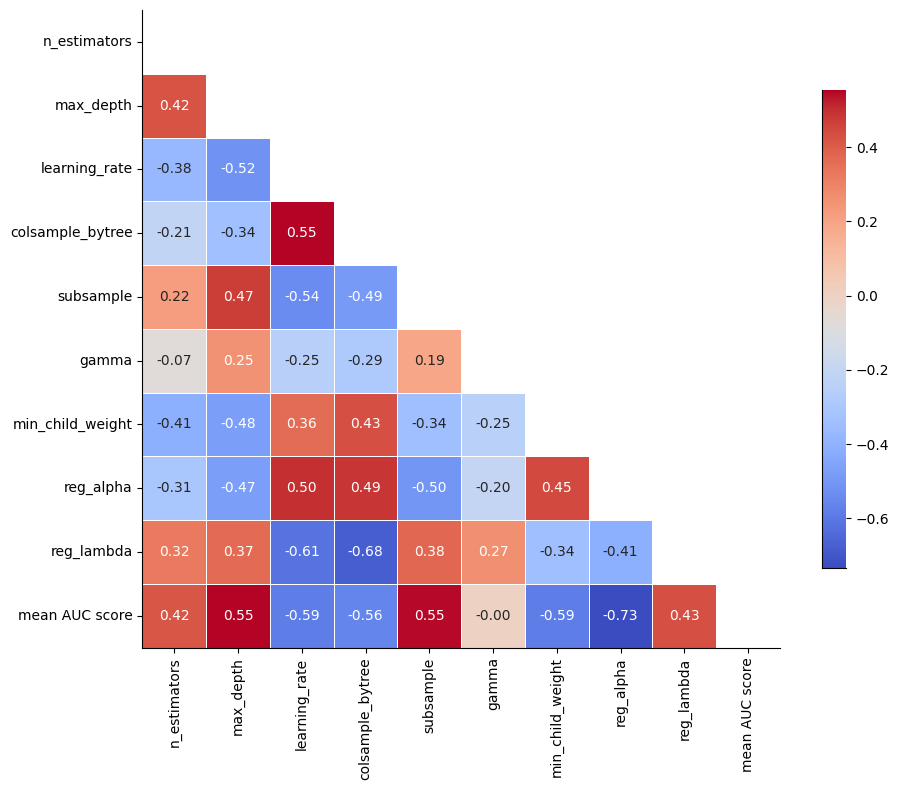

In [34]:


params_df = pd.DataFrame(xg_trial_df['params'].tolist())

# Concatenate with original DataFrame (excluding the old 'params' column)
df_expanded = pd.concat([params_df, xg_trial_df['mean_score']], axis=1)
#df_expanded = pd.concat([params_df, xg_trial_df.rename(columns={'mean_score': 'mean_AUC'})], axis=1)
df_expanded = df_expanded.drop(['tree_method'],axis=1)
df_expanded = pd.concat([params_df, xg_trial_df.rename(columns={'mean_score': 'mean AUC score'})['mean AUC score']], axis=1)
corr_matrix = df_expanded.corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Define a colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Draw the heatmap with annotation
sns.heatmap(
    corr_matrix, mask=mask, cmap=cmap, annot=True, fmt=".2f",
    square=True, linewidths=0.5, cbar_kws={"shrink": 0.75}
)

# Highlight correlations with mean_score
\
sns.despine()
plt.tight_layout()
plt.savefig('optuna_figure_hpo.png', dpi=300)
plt.show()
#df_expanded

In [36]:
def train_xgboost_with_hyp_cv(X, y, method, model_name, n_splits=10, random_state=42):
    """
    Trains an XGBoost classifier with cross-validation using optimized hyperparameters.

    Parameters:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target labels.
        method (str): Method name for tracking results.
        model_name (str): Model name for tracking results.
        n_splits (int): Number of cross-validation folds.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: Cross-validation results.
        list: List of trained models.
    """

    # Stratified K-Fold ensures balanced class distribution across folds
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    metrics_list = []
    models = []

    # Define the best hyperparameters
    best_params = {
        'n_estimators': 222,
        'max_depth': 3,
        'learning_rate': 0.07761801976733156,
        'colsample_bytree': 0.8944010680895353,
        'subsample': 0.747042067331029,
        'gamma': 0.6184384551812381,
        'min_child_weight': 1,
        'reg_alpha': 0.7418258785328468,
        'reg_lambda': 4.467400613629235
    }

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        print(f"Training Fold {fold + 1}/{n_splits}...")

        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Initialize and train the XGBoost classifier with best hyperparameters
        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=random_state,
            tree_method="gpu_hist",  # Use GPU for faster training
            n_jobs=-1,  # Use all CPU cores for multi-threading
            **best_params  # Inject the best hyperparameters
        )
        model.fit(X_train, y_train)
        models.append(model)

        # Make predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        auc_pr = average_precision_score(y_test, y_pred_proba)

        # Store metrics
        metrics_list.append({
            'fold': fold + 1,
            'accuracy': accuracy,
            'roc_auc': roc_auc,
            'auc_pr': auc_pr,
            'method': method,
            'model_name': model_name
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(metrics_list)
    
    return results_df, models

In [37]:
#esm_xg_train_df[esm_xg_train_df['mean_score'] == esm_xg_train_df['mean_score'].max()]['fold_scores']
#eve_xg_train_df[eve_xg_train_df['mean_score'] == eve_xg_train_df['mean_score'].max()]['fold_scores']
#xg_trial_df[xg_trial_df['mean_score']==xg_trial_df['mean_score'].max()]['fold_scores']
#fold_metrics_xg_hadamard_df

fold_scores_esm_optuna = esm_xg_train_df.loc[esm_xg_train_df['mean_score'].idxmax(), ['fold_scores', 'accuracy_scores']]
fold_scores_eve_optuna = eve_xg_train_df.loc[eve_xg_train_df['mean_score'].idxmax(), ['fold_scores', 'accuracy_scores']]
fold_scores_def_optuna = xg_trial_df.loc[xg_trial_df['mean_score'].idxmax(), ['fold_scores', 'accuracy_scores']]
fold_scores_def_optuna

fold_scores_esm_optuna_df = pd.DataFrame({
    'roc_auc': fold_scores_esm_optuna['fold_scores'],
    'accuracy': fold_scores_esm_optuna['accuracy_scores']
})
fold_scores_esm_optuna_df['fold'] = fold_scores_esm_optuna_df.index
fold_scores_esm_optuna_df['method'] = 'ESM1B + Hadamard + PS + gIDRc'
fold_scores_esm_optuna_df['model_name'] = "XGboost/Optuna"
fold_scores_eve_optuna_df =  pd.DataFrame({
    'roc_auc': fold_scores_eve_optuna['fold_scores'],
    'accuracy': fold_scores_eve_optuna['accuracy_scores']
})
fold_scores_eve_optuna_df['fold'] = fold_scores_eve_optuna_df.index
fold_scores_eve_optuna_df['method'] = 'EVE + Hadamard + PS + gIDRc'
fold_scores_eve_optuna_df['model_name'] = "XGboost/Optuna"
fold_scores_def_optuna_df =  pd.DataFrame({
    'roc_auc': fold_scores_def_optuna['fold_scores'],
    'accuracy': fold_scores_def_optuna['accuracy_scores']
})
fold_scores_def_optuna_df['fold'] = fold_scores_def_optuna_df.index
fold_scores_def_optuna_df['method'] = 'Hadamard + PS + gIDRc'
fold_scores_def_optuna_df['model_name'] = "XGboost/Optuna"
fold_metrics_xg_hadamard_og_df = fold_metrics_xg_hadamard_df[['fold', 'roc_auc', 'accuracy', 'method', 'model_name']]
fold_scores_def_optuna_df['roc_auc'].mean()
fold_scores_eve_optuna_df['roc_auc'].mean()
fold_scores_esm_optuna_df['roc_auc'].mean()

0.9378429263044648

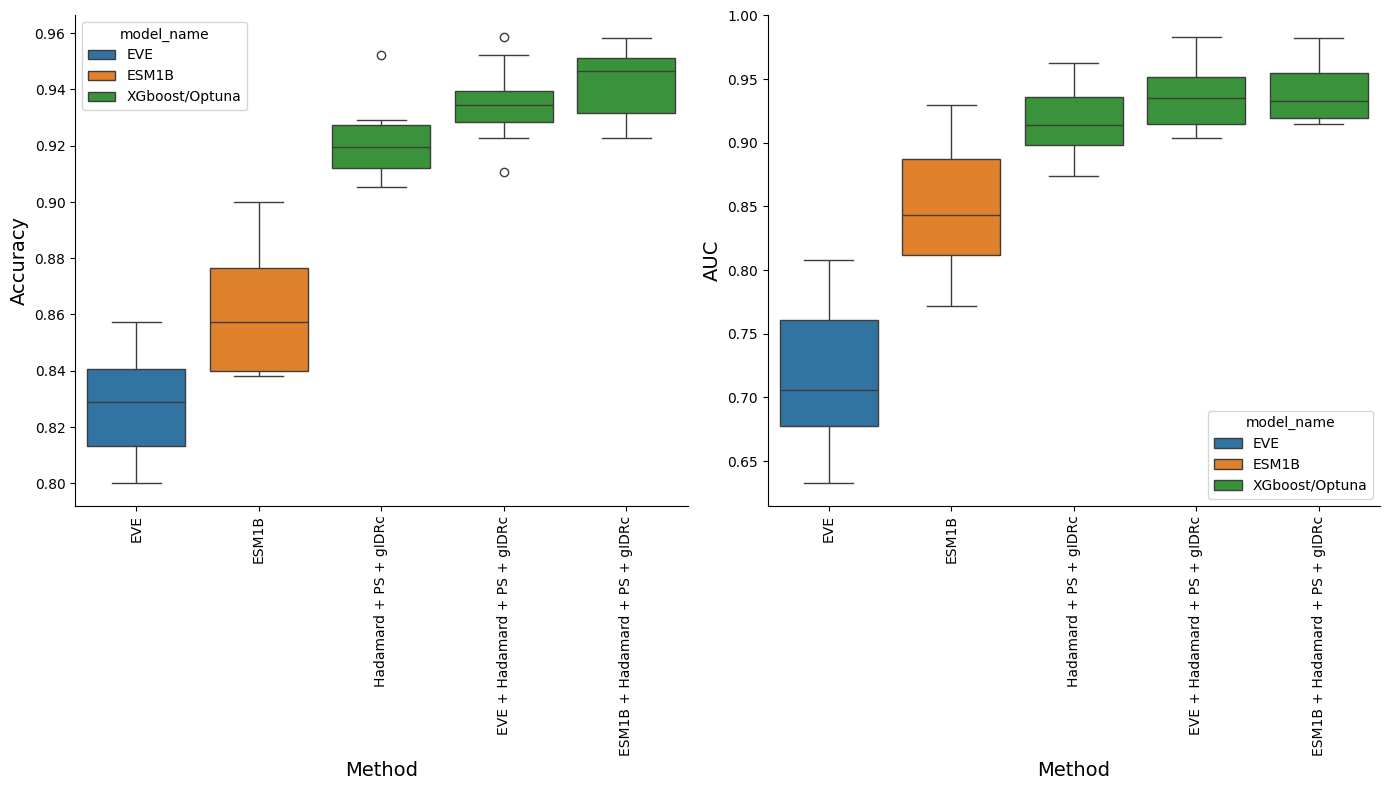

In [38]:
noemb_results = '/projects/wangc/rohan/missense_prediction/disorder/disorder/src/results_noemb_results.initial.multiple_models.csv'
noemb_results_df = pd.read_csv(noemb_results)
model_to_keep = ['EVE', 'ESM1B']

noemb_results_df = noemb_results_df[noemb_results_df['model'].isin(model_to_keep)]
noemb_results_df = noemb_results_df[['fold', 'auc', 'accuracy', 'method', 'model']]
noemb_results_df.columns = ['fold', 'roc_auc', 'accuracy', 'method', 'model_name']
result_all_df = pd.concat([noemb_results_df, fold_scores_def_optuna_df, fold_scores_eve_optuna_df, fold_scores_esm_optuna_df], axis=0)
result_all_df


diverse_palette = sns.color_palette("tab10") 
plt.figure(figsize=(14, 8))


plt.subplot(1, 2, 1)
sns.boxplot(data=result_all_df, x='method', y='accuracy', hue='model_name', palette=diverse_palette)
#plt.title('Accuracy by Method')
plt.xticks(rotation=90)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
#plt.grid(True)

# AUC box plot
plt.subplot(1, 2, 2)
sns.boxplot(data=result_all_df, x='method', y='roc_auc', hue='model_name', palette=diverse_palette)
#plt.title('AUC by Method')
plt.xticks(rotation=90)
plt.xlabel('Method', fontsize=14)
plt.ylabel('AUC', fontsize=14)
#plt.grid(True)
sns.despine()
plt.tight_layout()
plt.savefig('final_results_emb_box.png', dpi=300)
plt.show()

In [45]:
# Define methods to compare
methods = [
    "EVE", 
    "ESM1B", 
    "Hadamard + PS + gIDRc", 
    "EVE + Hadamard + PS + gIDRc", 
    "ESM1B + Hadamard + PS + gIDRc"
]

# Store results
results = []

# Loop through all method combinations
for i in range(len(methods)):
    for j in range(i+1, len(methods)):
        method1, method2 = methods[i], methods[j]
        
        # Extract ROC AUC scores
        scores1_roc = result_all_df[result_all_df["method"] == method1]["roc_auc"]
        scores2_roc = result_all_df[result_all_df["method"] == method2]["roc_auc"]
        scores1_roc_mean = scores1_roc.mean()
        scores2_roc_mean =  scores2_roc.mean()
        
        # Extract Accuracy scores
        scores1_acc = result_all_df[result_all_df["method"] == method1]["accuracy"]
        scores2_acc = result_all_df[result_all_df["method"] == method2]["accuracy"]
        scores1_acc_mean = scores1_acc.mean()
        scores2_acc_mean = scores2_acc.mean()
        
        # Compute Mean Scores
        mean_auc1, mean_auc2 = scores1_roc.mean(), scores2_roc.mean()
        mean_acc1, mean_acc2 = scores1_acc.mean(), scores2_acc.mean()

        # Perform Mann-Whitney U test for ROC AUC
        if not scores1_roc.empty and not scores2_roc.empty:
            stat_roc, p_roc = stats.mannwhitneyu(scores1_roc, scores2_roc, alternative="two-sided")
        else:
            stat_roc, p_roc = None, None

        # Perform Mann-Whitney U test for Accuracy
        if not scores1_acc.empty and not scores2_acc.empty:
            stat_acc, p_acc = stats.mannwhitneyu(scores1_acc, scores2_acc, alternative="two-sided")
        else:
            stat_acc, p_acc = None, None

        # Store results
        results.append([method1, method2, stat_roc, p_roc, stat_acc, p_acc, mean_auc1, mean_auc2, mean_acc1, mean_acc2])

# Convert results to DataFrame for better visualization
comparison_result_final_df = pd.DataFrame(
    results, 
    columns=[
        "Method_1", "Method_2", "U_Statistic_ROC", "P_Value_ROC", "U_Statistic_Acc", 
        "P_Value_Acc", "Mean_AUC_1", "Mean_AUC_2", "Mean_Accuracy_1", "Mean_Accuracy_2"
    ]
)

comparison_result_final_df.to_csv("../output/final_result_table_model.csv", index=False)

In [40]:
model_path = "/projects/wangc/rohan/missense_prediction/disorder/disorder/src/xgboost_results/default_best_xgboost_model.pkl"
with open(model_path, "rb") as f:
    model_xg = pickle.load(f)


feature_names = model_xg.get_booster().feature_names
hadamard_X.to_csv("training_data.csv", index=None)
#explainer = shap.Explainer(model_xg, masker=shap.maskers.Independent(hadamard_X))
#explainer = shap.Explainer(model_xg, hadamard_X)
#shap_values = explainer(average_X)
#shap.plots.heatmap(shap_values)


In [41]:
#shap_importance = pd.DataFrame({
#    'Feature': hadamard_X.columns,
#    'Importance': np.abs(shap_values.values).mean(axis=0)
#}).sort_values(by='Importance', ascending=False)

# Normalize to get probabilities
#shap_importance['Probability'] = shap_importance['Importance'] / shap_importance['Importance'].sum()
#shap_importance = shap_importance.head(10)
# Display feature importance with probabilities
#print(shap_importance.Feature.tolist())

#all_features = ['abs_delta_gravy', 'delta_emb_hadamard_value_217', 'delta_emb_hadamard_value_536', 'delta_emb_hadamard_value_138', 'abs_delta_IEP', 'delta_emb_hadamard_value_986', 'abs_delta_molecular_weight', 'delta_emb_hadamard_value_432', 'delta_emb_hadamard_value_484', 'abs_delta_end_to_end_distance']
#group_1 = ['abs_delta_gravy', 'abs_delta_IEP']
#group_2 = ['delta_emb_hadamard_value_217', 'delta_emb_hadamard_value_536', 'delta_emb_hadamard_value_138', 'delta_emb_hadamard_value_986', 'abs_delta_molecular_weight', 'delta_emb_hadamard_value_432', 'delta_emb_hadamard_value_484']
#group_3 = ['abs_delta_end_to_end_distance']

# Define colors for groups
#group_colors = {feature: 'red' if feature in group_1 else 'blue' if feature in group_2 else 'green' for feature in all_features}
#plt.figure(figsize=(10, 6))
#plt.bar(shap_importance['Feature'], shap_importance['Probability'], color=[group_colors.get(f, 'black') for f in shap_importance['Feature']])
#plt.xlabel('Features', fontsize=14, weight='bold')
#plt.ylabel('Probability', fontsize=14, weight='bold')
#plt.xticks(rotation=90, fontsize=12)
#plt.tight_layout()
#sns.despine()


#from matplotlib.patches import Patch
#legend_labels = [Patch(color='red', label='Phase Separation'),
#                 Patch(color='blue', label='ProtTransTM'),
#                 Patch(color='green', label='gIDRc')]
#plt.legend(handles=legend_labels, loc='upper right')
#plt.tight_layout()
#plt.savefig('feature_importance_model.png', dpi=300)
#plt.show()


In [42]:
#results_df = pd.concat([emb_eve_results_df, emb_results_df, noemb_results_df, noemb_deltas_results_df], axis=0)
#results_df = results_df[results_df['model'] == 'xgboost']
#results_df.method.value_counts()
#keep_method_eve = ['EVE', 'GIDRC + EVE', 'PS + GIDRc + EVE', 'average_protTrans + PS + GIDRC',  'average_protTrans + PS + GIDRC + EVE']
#keep_method_esm = ['ESM1B', 'GIDRC + ESM1B', 'PS + GIDRC + ESM1B', 'average_protTrans + PS + GIDRC', 'average_protTrans + PS + GIDRC + ESM1B']
#results_eve_df = results_df[results_df['method'].isin(keep_method_eve)]
#results_esm_df = results_df[results_df['method'].isin(keep_method_esm)]
#results_eve_df = results_eve_df[(results_eve_df['model'] != 'MLP') & (results_eve_df['model'] != 'Random Forest')]
#results_esm_df = results_esm_df[(results_esm_df['model'] != 'MLP') & (results_esm_df['model'] != 'Random Forest')]
#results_df.method.value_counts()

#results_df = results_df[results_df['model'] != 'optuna + xgboost']
#results_df

In [43]:
#plt.figure(figsize=(14, 10))

# Define the custom order for the methods
#method_order = ['EVE',  'gIDRc + EVE', 'PS + gIDRc + EVE', 'average_protTrans + PS + gIDRc', 'average_protTrans + PS + gIDRc + EVE']

# Accuracy box plot
#plt.subplot(1, 2, 1)
#sns.boxplot(data=results_eve_df, x='method', y='accuracy', palette='viridis', order=method_order)
#plt.title('Accuracy by Method')
#plt.xlabel('Method', fontsize=14)
#plt.ylabel('Accuracy', fontsize=14)
#plt.xticks(rotation=90, fontsize=14)  # Rotate x-axis labels by 90 degrees

# AUC box plot
#plt.subplot(1, 2, 2)
#sns.boxplot(data=results_eve_df, x='method', y='auc', palette='viridis', order=method_order)
#plt.title('AUC by Method')
#plt.xlabel('Method', fontsize=14)
#plt.ylabel('AUC', fontsize=14)
#plt.xticks(rotation=90, fontsize=14)  # Rotate x-axis labels by 90 degrees

#plt.tight_layout()
#sns.despine()
#plt.savefig('AUC_accuracy_model_results_eve.png', dpi=300)
#plt.show()

In [44]:
#plt.figure(figsize=(14, 10))

# Define the custom order for the methods
#method_order = ['ESM1B',  'pIDRc + ESM1B', 'PS + pIDRc + ESM1B', 'average_protTrans + PS + pIDRC', 'average_protTrans + PS + pIDRC + ESM1B']

# Accuracy box plot
#plt.subplot(1, 2, 1)
#sns.boxplot(data=results_esm_df, x='method', y='accuracy', palette='viridis', order=method_order)
#plt.title('Accuracy by Method')
#plt.xlabel('Method', fontsize=14)
#plt.ylabel('Accuracy', fontsize=14)
#plt.xticks(rotation=90, fontsize=14)  # Rotate x-axis labels by 90 degrees

# AUC box plot
#plt.subplot(1, 2, 2)
#sns.boxplot(data=results_esm_df, x='method', y='auc', palette='viridis', order=method_order)
#plt.title('AUC by Method')
#plt.xlabel('Method', fontsize=14)
#plt.ylabel('AUC', fontsize=14)
#plt.xticks(rotation=90, fontsize=14)  # Rotate x-axis labels by 90 degrees
#sns.despine()
#plt.savefig('AUC_accuracy_model_results_esm1b.png', dpi=300)
#plt.tight_layout()
#plt.show()